Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


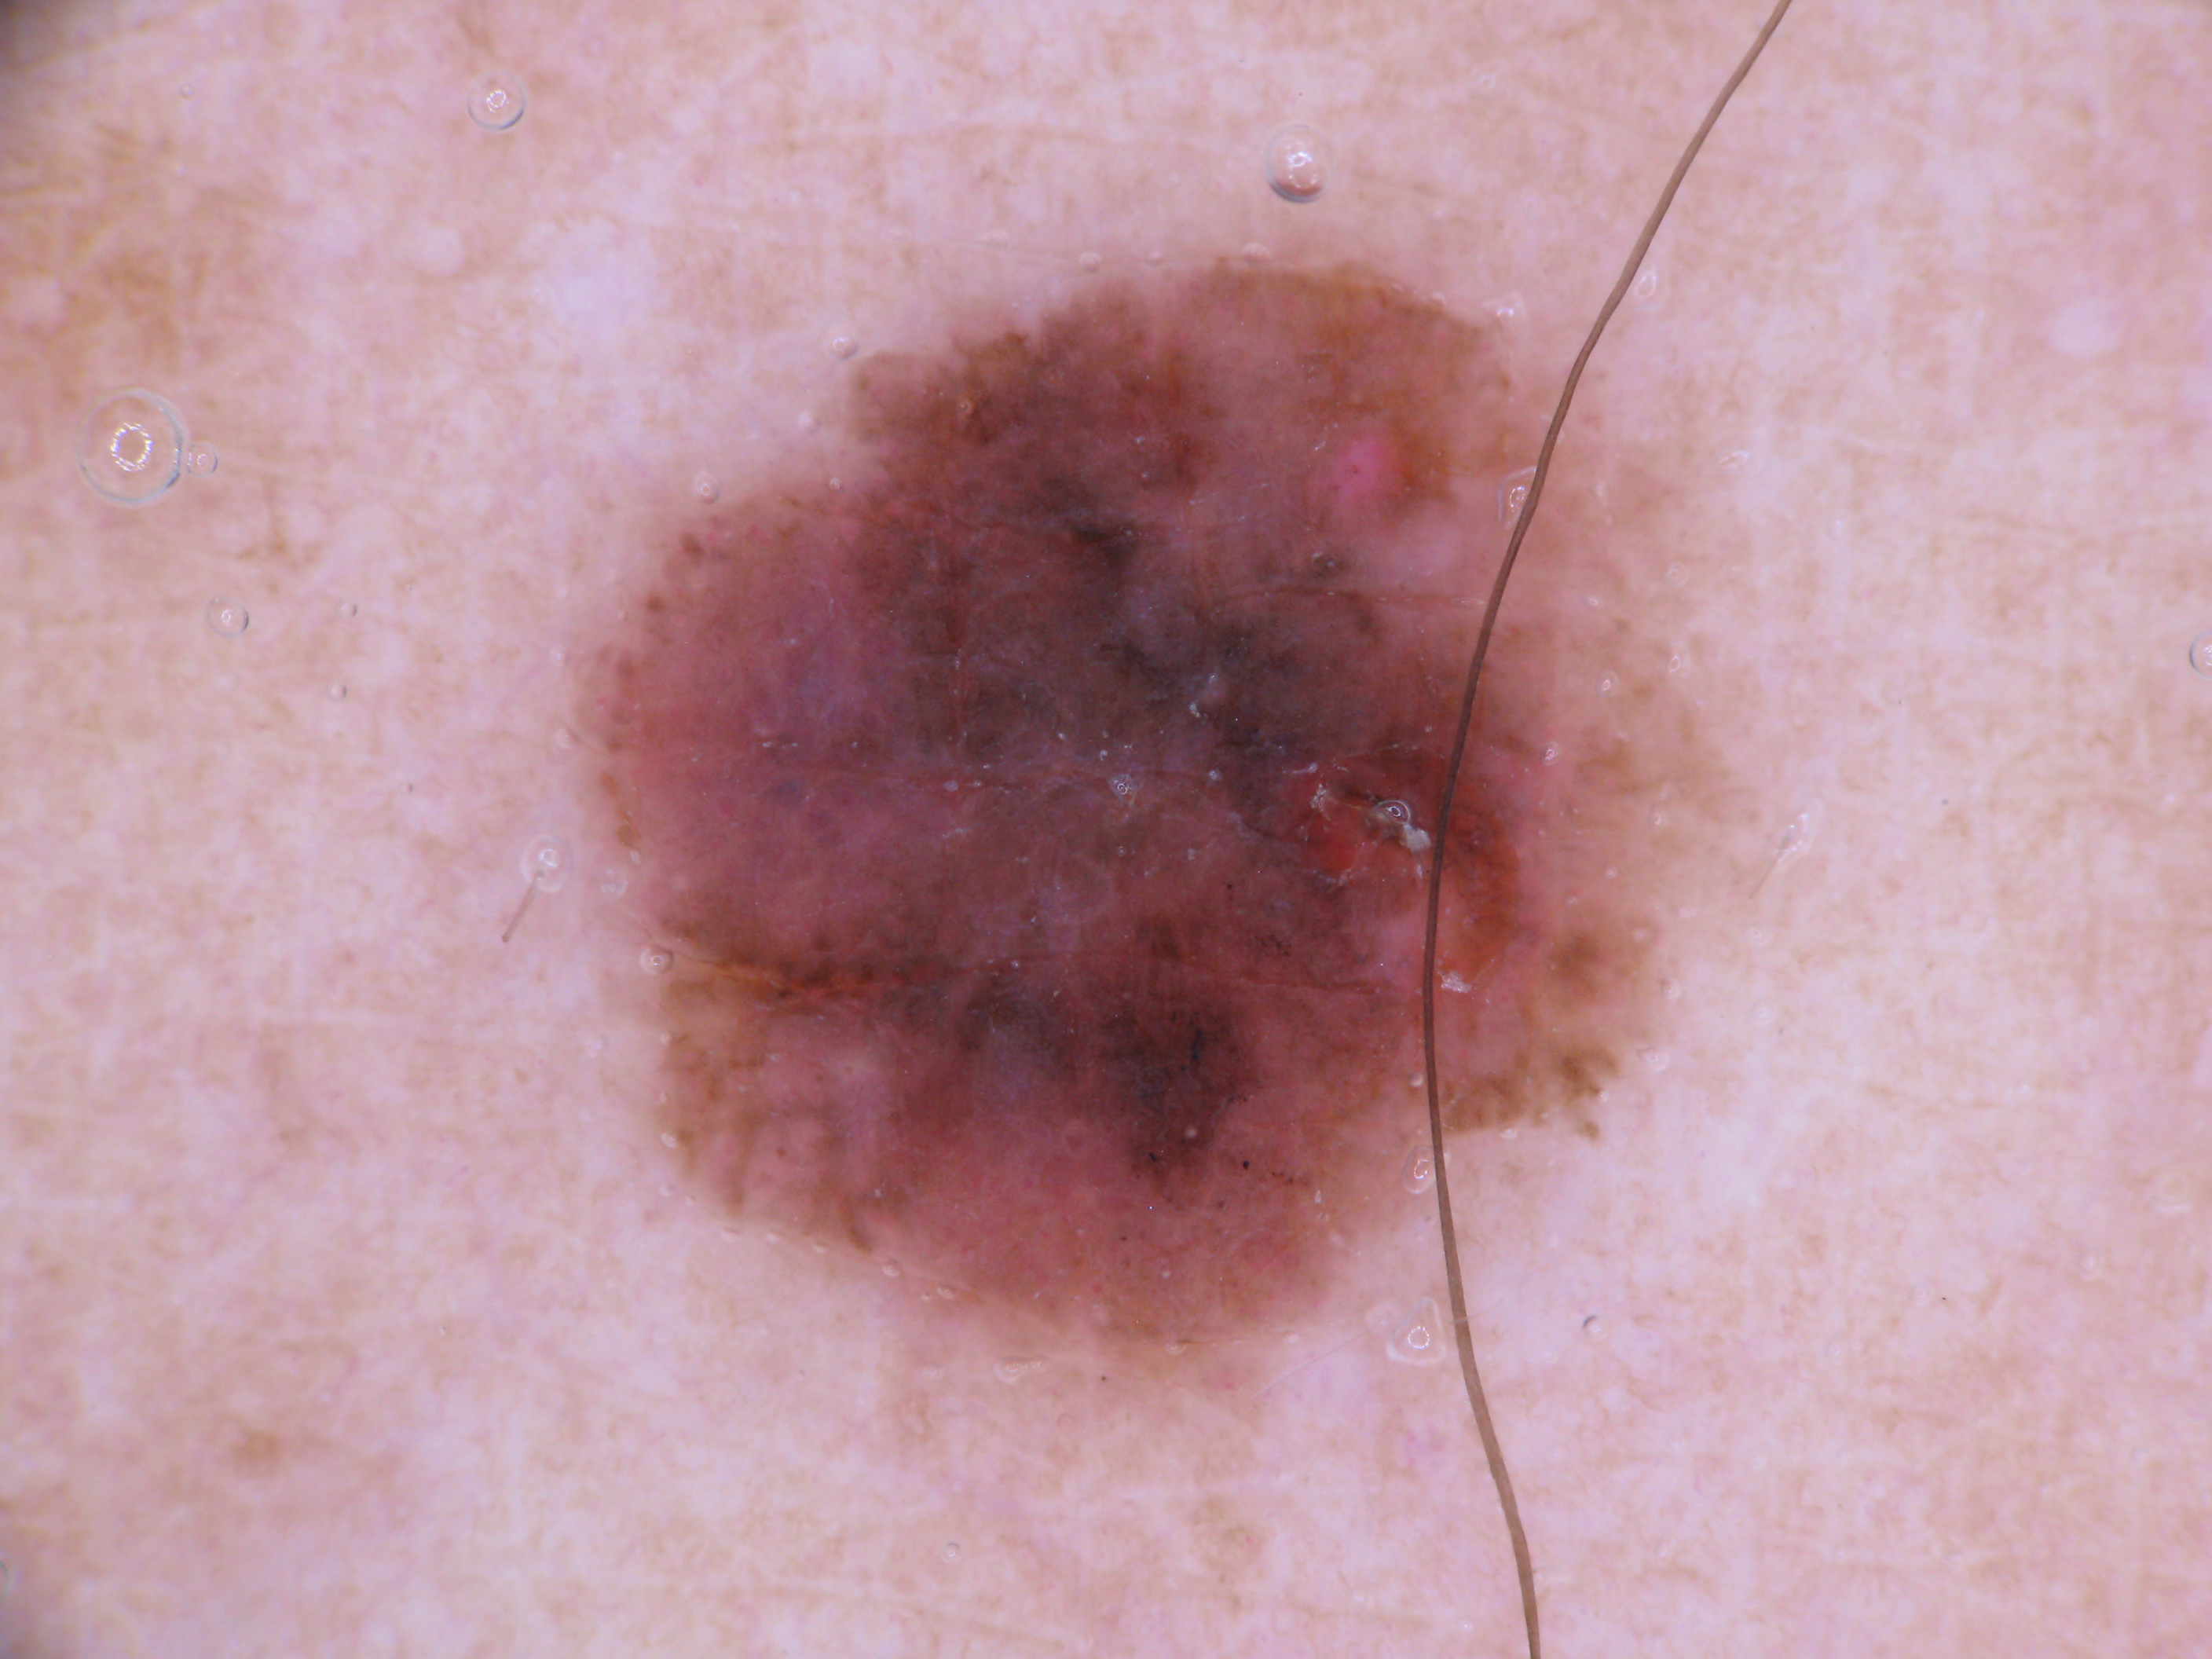

In [ ]:
# Image representaion of disease Melanoma
melanoma = list(data_dir_train.glob('melanoma/*'))
PIL.Image.open(str(melanoma[0]))

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split=0.2,subset="training",seed=123,image_size=(img_height, img_width),batch_size=batch_size,labels="inferred")

Found 15739 files belonging to 9 classes.
Using 12592 files for training.


In [ ]:

## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split=0.2,subset="validation",seed=123,image_size=(img_height,img_width),batch_size=batch_size,labels="inferred")

Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

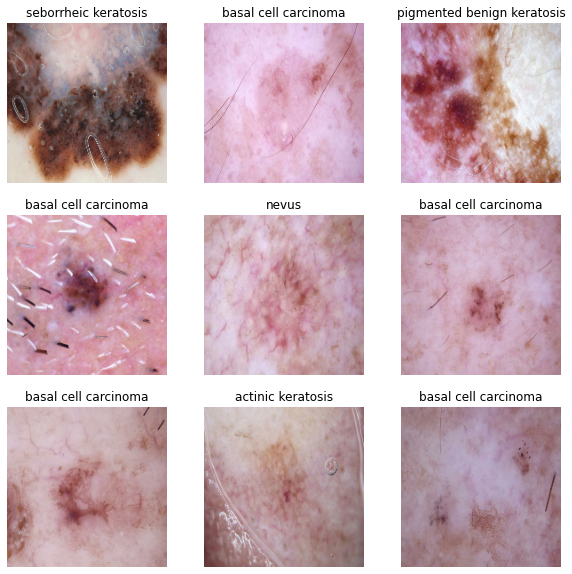

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
## Rescaling the training dataset
### Your code goes here
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.058497414 0.8305556


In [ ]:
#

num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    layers.Conv2D(16,3,padding="same",activation="relu"),
                    layers.MaxPooling2D(),
                    layers.Conv2D(32,3,padding="same",activation="relu"),
                    layers.MaxPooling2D(),
                    layers.Conv2D(64, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Flatten(),
                    layers.Dense(128,activation="relu"),
                    layers.Dense(9)

                    
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
394/394 [==============================] - 713s 2s/step - loss: 1.9643 - accuracy: 0.2660 - val_loss: 1.3028 - val_accuracy: 0.5183
Epoch 2/20
394/394 [==============================] - 8s 19ms/step - loss: 1.1515 - accuracy: 0.5843 - val_loss: 0.8768 - val_accuracy: 0.6854
Epoch 3/20
394/394 [==============================] - 7s 19ms/step - loss: 0.7507 - accuracy: 0.7321 - val_loss: 0.5786 - val_accuracy: 0.7922
Epoch 4/20
394/394 [==============================] - 7s 19ms/step - loss: 0.4856 - accuracy: 0.8322 - val_loss: 0.4331 - val_accuracy: 0.8545
Epoch 5/20
394/394 [==============================] - 7s 19ms/step - loss: 0.3122 - accuracy: 0.8936 - val_loss: 0.4237 - val_accuracy: 0.8522
Epoch 6/20
394/394 [==============================] - 8s 19ms/step - loss: 0.2673 - accuracy: 0.9042 - val_loss: 0.3317 - val_accuracy: 0.8875
Epoch 7/20
394/394 [==============================] - 8s 19ms/step - loss: 0.1935 - accuracy: 0.9328 - val_loss: 0.3373 - val_accuracy: 0.8990

### Visualizing training results

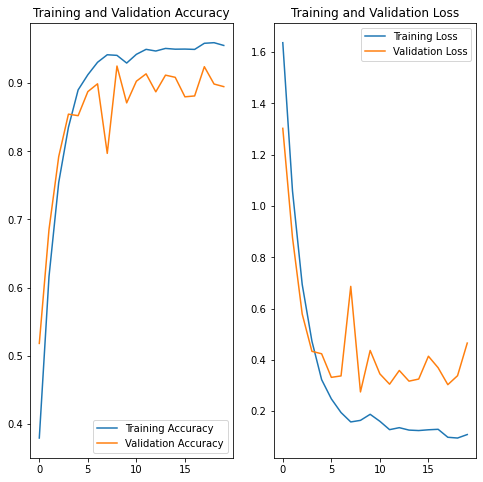

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit



###  Yes, Model is overfitted. To prevent this we use Data Augmentation.

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

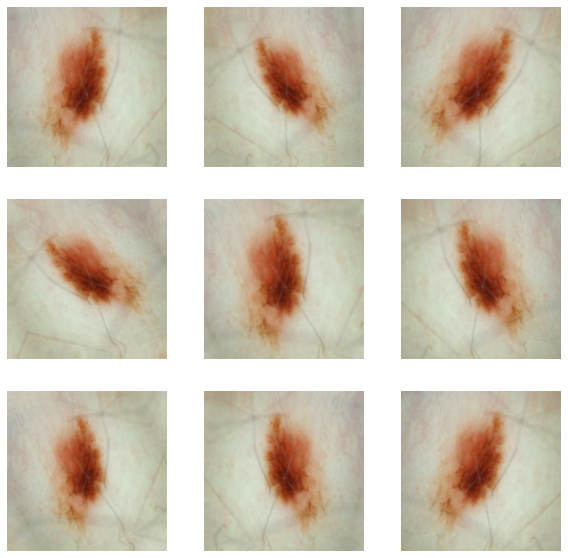

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[1].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [ ]:
model.compile(optimizer="sgd",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ["accuracy"])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
394/394 [==============================] - 9s 21ms/step - loss: 2.1672 - accuracy: 0.1520 - val_loss: 1.9210 - val_accuracy: 0.2475
Epoch 2/20
394/394 [==============================] - 8s 21ms/step - loss: 1.9511 - accuracy: 0.2531 - val_loss: 1.7095 - val_accuracy: 0.3562
Epoch 3/20
394/394 [==============================] - 8s 21ms/step - loss: 1.7275 - accuracy: 0.3533 - val_loss: 1.5981 - val_accuracy: 0.4058
Epoch 4/20
394/394 [==============================] - 8s 21ms/step - loss: 1.5670 - accuracy: 0.4132 - val_loss: 1.4676 - val_accuracy: 0.4604
Epoch 5/20
394/394 [==============================] - 8s 21ms/step - loss: 1.4813 - accuracy: 0.4512 - val_loss: 1.3925 - val_accuracy: 0.4795
Epoch 6/20
394/394 [==============================] - 8s 21ms/step - loss: 1.3853 - accuracy: 0.4835 - val_loss: 1.2730 - val_accuracy: 0.5475
Epoch 7/20
394/394 [==============================] - 8s 21ms/step - loss: 1.3259 - accuracy: 0.5140 - val_loss: 1.1749 - val_accuracy: 0.5618

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),
  #layers.Dropout(0.25),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),
  #layers.Dropout(0.25),
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),
  #layers.Dropout(0.25),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25),

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)

])

In [ ]:
model.compile(optimizer="adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ["accuracy"])

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
394/394 [==============================] - 10s 23ms/step - loss: 1.9375 - accuracy: 0.2471 - val_loss: 1.5489 - val_accuracy: 0.4229
Epoch 2/20
394/394 [==============================] - 9s 22ms/step - loss: 1.4469 - accuracy: 0.4488 - val_loss: 1.2872 - val_accuracy: 0.5103
Epoch 3/20
394/394 [==============================] - 9s 22ms/step - loss: 1.2849 - accuracy: 0.5043 - val_loss: 1.1108 - val_accuracy: 0.5691
Epoch 4/20
394/394 [==============================] - 9s 22ms/step - loss: 1.1582 - accuracy: 0.5562 - val_loss: 1.0312 - val_accuracy: 0.6028
Epoch 5/20
394/394 [==============================] - 9s 22ms/step - loss: 1.0689 - accuracy: 0.5962 - val_loss: 0.9854 - val_accuracy: 0.6130
Epoch 6/20
394/394 [==============================] - 9s 22ms/step - loss: 0.9438 - accuracy: 0.6376 - val_loss: 0.7592 - val_accuracy: 0.7188
Epoch 7/20
394/394 [==============================] - 9s 22ms/step - loss: 0.8633 - accuracy: 0.6673 - val_loss: 0.7240 - val_accuracy: 0.725

### Visualizing the results

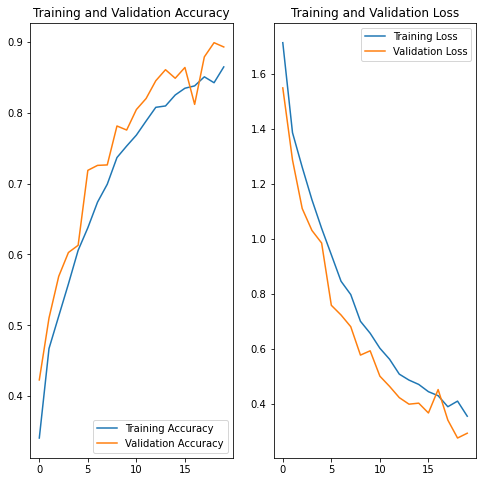

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

#### **Todo:** Write your findings here:

#### - Which class has the least number of samples?
####- Ans:  "Pigmented benign keratosis" has least number of samples.

#### - Which classes dominate the data in terms proportionate number of samples?
#### - Nevus

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD9BA047E50>:   0%|          | 1/500 [00:00<01:00,  8.30 Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDA0C17D6D0>: 100%|██████████| 500/500 [00:18<00:00, 27.02 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD9BA008690>: 100%|██████████| 500/500 [00:18<00:00, 27.48 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD9AE752190>: 100%|██████████| 500/500 [00:18<00:00, 26.68 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FD9BA06ECD0>: 100%|██████████| 500/500 [01:28<00:00,  5.66 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD9AE6FDD10>: 100%|██████████| 500/500 [01:17<00:00,  6.47 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD9BA03B510>: 100%|██████████| 500/500 [00:18<00:00, 26.66 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD9C2363D90>: 100%|██████████| 500/500 [00:39<00:00, 12.53 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD9BCF05490>: 100%|██████████| 500/500 [00:18<00:00, 26.89 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD9AE7B7FD0>:   0%|          | 1/500 [00:00<01:21,  6.13 Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD9C216F050>: 100%|██████████| 500/500 [00:18<00:00, 27.27 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

18000


In [ ]:
#import glob2
from glob import glob

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028937.jpg_70226d1f-2fe5-48c5-8142-fc28169e882c.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024665.jpg_88a48938-749b-4126-9d27-3477bc67a5e1.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027744.jpg_0b2d6476-4641-442c-bd55-a8fecbb41143.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028687.jpg_c2877da8-7aea-448d-9930-3026d0494380.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imagin

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
df2

Path                 Label
0      /content/gdrive/My Drive/CNN_assignment/Skin c...  basal cell carcinoma
1      /content/gdrive/My Drive/CNN_assignment/Skin c...  basal cell carcinoma
2      /content/gdrive/My Drive/CNN_assignment/Skin c...  basal cell carcinoma
3      /content/gdrive/My Drive/CNN_assignment/Skin c...  basal cell carcinoma
4      /content/gdrive/My Drive/CNN_assignment/Skin c...  basal cell carcinoma
...                                                  ...                   ...
17995  /content/gdrive/My Drive/CNN_assignment/Skin c...  seborrheic keratosis
17996  /content/gdrive/My Drive/CNN_assignment/Skin c...  seborrheic keratosis
17997  /content/gdrive/My Drive/CNN_assignment/Skin c...  seborrheic keratosis
17998  /content/gdrive/My Drive/CNN_assignment/Skin c...  seborrheic keratosis
17999  /content/gdrive/My Drive/CNN_assignment/Skin c...  seborrheic keratosis

[18000 rows x 2 columns]

In [ ]:
df2['Label'].value_counts()

dermatofibroma                2000
melanoma                      2000
vascular lesion               2000
seborrheic keratosis          2000
nevus                         2000
pigmented benign keratosis    2000
actinic keratosis             2000
basal cell carcinoma          2000
squamous cell carcinoma       2000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ="training" ## Todo choose the correct parameter value, so that only training data is refered to,"",
  ,image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20239 files belonging to 9 classes.
Using 16192 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20239 files belonging to 9 classes.
Using 4047 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
num_classes=9
model = Sequential([
  
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
  layers.Dropout(0.25),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
  layers.Dropout(0.25),
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
  layers.Dropout(0.25),

  
  layers.Dropout(0.25),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation="softmax")

])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
506/506 [==============================] - 123s 239ms/step - loss: 2.7899 - accuracy: 0.2792 - val_loss: 4.0876 - val_accuracy: 0.2347
Epoch 2/30
506/506 [==============================] - 107s 210ms/step - loss: 1.5211 - accuracy: 0.4217 - val_loss: 1.5850 - val_accuracy: 0.4253
Epoch 3/30
506/506 [==============================] - 104s 203ms/step - loss: 1.3041 - accuracy: 0.4889 - val_loss: 1.6766 - val_accuracy: 0.4851
Epoch 4/30
506/506 [==============================] - 104s 203ms/step - loss: 1.1640 - accuracy: 0.5549 - val_loss: 2.6473 - val_accuracy: 0.4497
Epoch 5/30
506/506 [==============================] - 103s 202ms/step - loss: 1.0405 - accuracy: 0.6036 - val_loss: 1.2020 - val_accuracy: 0.5488
Epoch 6/30
506/506 [==============================] - 103s 201ms/step - loss: 0.9036 - accuracy: 0.6511 - val_loss: 0.9506 - val_accuracy: 0.6496
Epoch 7/30
506/506 [==============================] - 103s 201ms/step - loss: 0.7820 - accuracy: 0.7074 - val_loss: 1.0051 -

#### **Todo:**  Visualize the model results

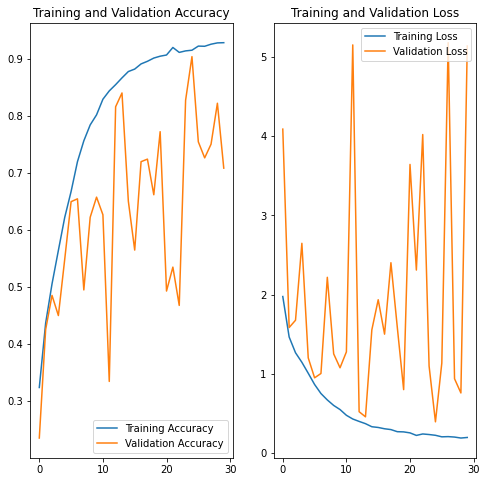

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?


#### Still there is an overfitting problem that we saw. So I think hyperparameter would help us to get rid of overfitting 


### Model without batchnormalization layer

In [ ]:
num_classes=9
model = Sequential([
  
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
  layers.Dropout(0.25),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
  layers.Dropout(0.25),
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
  layers.Dropout(0.25),

  
  layers.Dropout(0.25),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation="softmax")

])

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
506/506 [==============================] - 100s 195ms/step - loss: 2.1387 - accuracy: 0.2339 - val_loss: 1.3501 - val_accuracy: 0.4868
Epoch 2/30
506/506 [==============================] - 99s 194ms/step - loss: 1.2439 - accuracy: 0.5304 - val_loss: 1.0676 - val_accuracy: 0.6247
Epoch 3/30
506/506 [==============================] - 99s 194ms/step - loss: 0.9456 - accuracy: 0.6543 - val_loss: 0.7198 - val_accuracy: 0.7591
Epoch 4/30
506/506 [==============================] - 99s 194ms/step - loss: 0.7273 - accuracy: 0.7343 - val_loss: 0.5534 - val_accuracy: 0.8231
Epoch 5/30
506/506 [==============================] - 99s 194ms/step - loss: 0.5216 - accuracy: 0.8102 - val_loss: 0.4631 - val_accuracy: 0.8347
Epoch 6/30
506/506 [==============================] - 99s 193ms/step - loss: 0.4045 - accuracy: 0.8555 - val_loss: 0.4414 - val_accuracy: 0.8550
Epoch 7/30
506/506 [==============================] - 99s 193ms/step - loss: 0.3376 - accuracy: 0.8744 - val_loss: 0.3423 - val_a

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()